# WIP: Isolation Forest
Isolation forest is an unsupervised training algorithm to identify outliers / anomalies in data. The algorithm works in the following way:

1. The data is randomly and recursively partitioned and represented as a trees (forest). At this stage the user defines the subsample and number of trees. From the paper is it suggested to used a subsample of 256 and 100 trees. Convergence is reached as the number of trees increases.

2. The end of the tree is reached once the recursive partition of the data is finished. It is expected that the distance takes for reach outliers is much shorter than for inliers

3. The distance of the path is averaged over the forest and normalised to calculate and anomaly score. A score of 1 is considered and outlier and value closed to 0 are considered inliers

**subsamples:** The number of samples to draw from the data to train each tree. In sklearn these data sets can be bootstrapped for each tree

**Note:** The anomaly score in sklearn is implemented slightly differently in that a score of -1 indicates and outlier and score of 1 an inlier.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [2]:
# Taken from http://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

In [3]:
# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

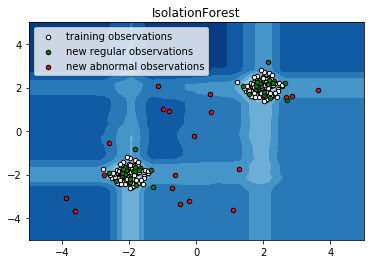

In [4]:
# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

The above plot shows the training observations in white, the new inlier observations in green and outliers in red. The prediction on `y_pred_outliers` should all be `-1` indicating the model has identified these observations as outliers:

In [5]:
y_pred_outliers

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])


All good, `y_pred_test` should be more difficult to predict for the model. Most observations should be labelled with 1 (inlier) but due the way the data is generated, by chance we may have some observations on the edge if the cluster/group which means it’s more difficult for the model to predict.


In [6]:
y_pred_test

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1, -1, -1,  1])

This seems to be the case. Below I have repeated the plot above execpt only with the training data (white dots) and the test data. Here the test data is coloured based on the model prediction: outlier = red and inlier = green. As you can see the model has labelled the observations as outliers which are on the edge of the group / cluster. 

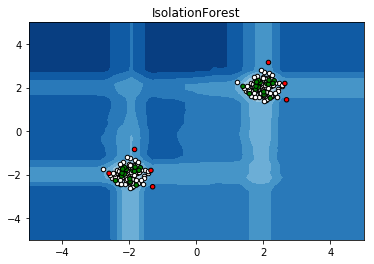

In [24]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c=['green' if i == 1 else 'red' for i in y_pred_test],
                 s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()

Hang on, but there are training observations which are "further" out than the observations labelled as outliers! Correct, the `IsolationForest` has a `contamination` parameter, which has a default value of `0.1` and represents the proportion of outliers in the dataset. This threshold is used to define the threshold of the decision function. Hence, the model will think these observations are outliers due to their location on the edge of the cluster / group. If these observations if predicted up on are likely to be labelled as outliers:

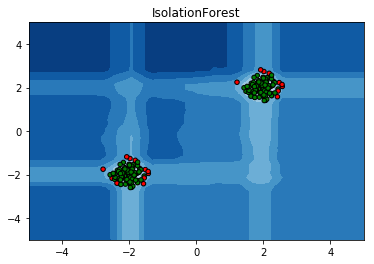

In [28]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c=['green' if i == 1 else 'red' for i in y_pred_train],
                 s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()

The plot above shows the predictions made on the training data, like in the previous plot observations predicted as an outlier are coloured red and inliers green. As you can see the model has labelled observations on the edge of the clusters as outliers.

If I re-train the model to have a `contamination` value of 0.0 then all the observations in the training data when predicted upon should be labelled as inliers:

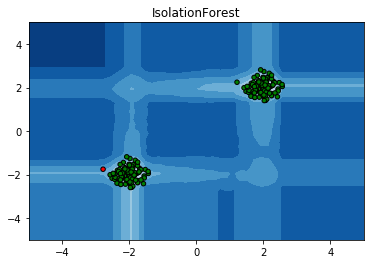

In [39]:
# fit the model
clf = IsolationForest(max_samples=100, contamination=0.0, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c=['green' if i == 1 else 'red' for i in y_pred_train],
                 s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()

Interestingly, this is not the case as we have a single observation labelled as an outlier (red dot). The logical reason here would be that the observation is rather far away from the other observations as is very easy to isolate and hence when predicted upon, labelled as an outlier.